In [1]:
import os
import h5py
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from IPython.display import HTML

from astropy import units as u

from visualize_foreground import *

R_sun = 6.957e10
%matplotlib inline

In [2]:
folder = "/mn/stornext/d10/data/tabjone/data/small_box_small_dt_high_res_k005/"    

snap_id = 0
snaps = []
n_procs = read_mpi_info(folder+"mpi_info.h5")


if n_procs > 1:
    exit_flag = False  # Flag to indicate when to exit the while loop
    while True:
        for i in range(n_procs):
            snap_filepath = folder + f"snap{snap_id}_{i}.h5"
            if os.path.exists(snap_filepath):
                snaps.append(snap_filepath)
            else:
                exit_flag = True  # Set the flag to True when the condition is met
                break  # Break out of the for loop
        snap_id += 1
        if exit_flag:
            break  # Break out of the while loop if the flag is set
else:
    while True:
        snap_filepath = folder + f"snap{snap_id}.h5"
        if os.path.exists(snap_filepath):
            snaps.append(snap_filepath)
            snap_id += 1
        else:
            break   

num_snaps = int(len(snaps)/n_procs)

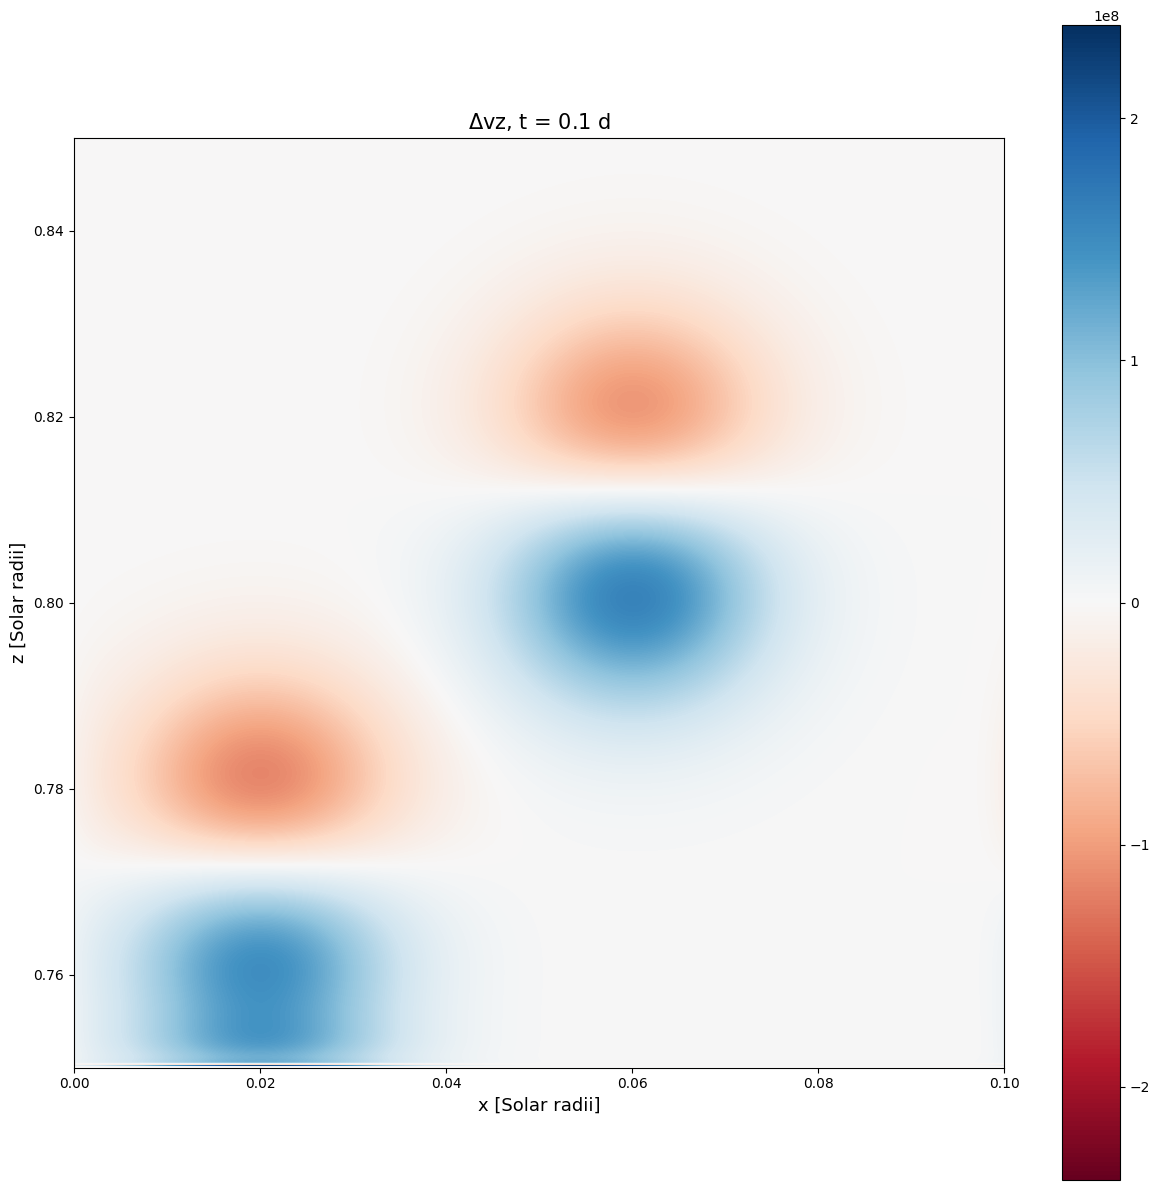

In [13]:
def plot(fig, ax, snap_nr, key):
    var_old, info = read_fg_mpi(snap_nr-1, n_procs, folder)
    var_new, info = read_fg_mpi(snap_nr, n_procs, folder)

    t, nz_ghost, dy, dz = info['t'], info['nz_ghost'], info['dy'], info['dz']  

    var_old = var_old[key]
    var_new = var_new[key]

    d = (var_new-var_old)[nz_ghost:-1-nz_ghost+1,:]

    background, _ = read_bg_mpi(n_procs, folder)
        
    t = t*u.s
    t = t.to("day")

    if (key=="T1"):
        d = d/(background["T0"][nz_ghost:-1-nz_ghost+1])[:, np.newaxis]
        ax.set_title(r"$\Delta$"+format_title(key)+"$/T_0$")
    elif (key=="rho1"):
        d = d/(background["rho0"][nz_ghost:-1-nz_ghost+1])[:, np.newaxis]
        ax.set_title(r"$\Delta$"+format_title(key)+r"$/\rho_0$")
    elif (key=="p1"):
        d = d/(background["p0"][nz_ghost:-1-nz_ghost+1])[:, np.newaxis]
        ax.set_title(r"$\Delta$"+format_title(key)+"$/p_0$")
    else:
        ax.set_title(r"$\Delta$"+format_title(key))
        
    ax.set_xlabel("x [Solar radii]", fontsize=13)
    ax.set_ylabel("z [Solar radii]", fontsize=13)

    vmax = np.max(abs(d))
    vmin = -vmax

    extent = np.array([info['y0'], info['y1'], info['z0'], info['z1']])/R_sun

    im =ax.imshow(d, origin="lower", extent=extent,vmin=vmin, vmax=vmax, cmap='RdBu')
        
    return im, t

def plot_all(fig, ax, snap_nr):
    gs = gridspec.GridSpec(2, 6, width_ratios=[1, 0.05, 1, 0.05, 1, 0.05], wspace=0.6, hspace=0.3)

    # Order of keys for plotting
    plot_order = ["T1", "rho1", "vy", "p1", "s1", "vz"]

    for idx, key in enumerate(plot_order):
        i, j = divmod(idx, 3)  # Convert 1D index to 2D indices
        # Create the subplot using GridSpec indexing
        ax = fig.add_subplot(gs[i, 2*j])
        
        im, t = plot(fig, ax, snap_nr, key)
        
        # Create a new axes for the colorbar next to the current subplot
        pos = ax.get_position()
        cax = fig.add_axes([pos.x1 + 0.01, pos.y0, 0.01, pos.height])
        cbar = plt.colorbar(im, cax=cax)

        # Set label for the colorbar
        #cbar.set_label(self.plot_params[key][3], fontsize=self.font_size)

        # Enforce scientific notation
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-1, 1))
        cbar.ax.yaxis.set_major_formatter(formatter)

fig = plt.figure(figsize=(15, 15))  # Create a figure
ax = fig.add_subplot(111)

def init_animation():
    im = plot(fig, ax, 1)
    #cbar = plt.colorbar(im)

def update_animation(snap_nr):
    global ax
    ax.clear()
    fig.clear()
    ax = fig.add_subplot(111)
    im = plot(fig, ax, snap_nr)
    cbar = plt.colorbar(im)


#self.plot_all(self.fig,self.num_snaps-1)
anim = FuncAnimation(fig, update_animation, interval=250, frames=range(1,num_snaps), init_func=init_animation)

save_name = "del_vz.mp4"

anim.save(save_name, writer='ffmpeg', fps=3, extra_args=['-vcodec', 'libx264'])